In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pmdarima as pm
import statistics
import seaborn as sns
import sklearn

In [2]:
data = pd.read_excel(r'C:\Users\user\Downloads\4.1\Project\Data files\Price_data.xlsx')
data.head()

,Date,Tomatoes,Kales,Cabbages
0,2012-01-01,3411.0,1328.0,2205.0
1,2012-02-01,4100.0,1985.0,2739.0
2,2012-03-01,3685.0,2049.0,3049.0
3,2012-04-01,2820.0,1580.0,2625.0
4,2012-05-01,3302.0,1206.0,2105.0


In [3]:
df = pd.DataFrame()
df['Tomatoes']=data['Tomatoes']
df['Kales']=data['Kales']
df['Cabbages']=data['Cabbages']
df['Date']= pd.to_datetime(data['Date'])
df=df.set_index('Date')

df.tail()

,Tomatoes,Kales,Cabbages
Date,,,
2020-08-01,3400.0,1100.0,1400.0
2020-09-01,3200.0,900.0,1400.0
2020-10-01,3600.0,1100.0,900.0
2020-11-01,1820.0,900.0,1000.0
2020-12-01,1860.0,700.0,841.0


In [4]:
#LOCATING ROWS WITH NULL VALUES
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]

rows_with_NaN

,Tomatoes,Kales,Cabbages
Date,,,
2019-12-01,NaN,NaN,NaN
2020-01-01,NaN,NaN,NaN
2020-05-01,NaN,NaN,NaN
2020-06-01,NaN,NaN,NaN


In [5]:
Tomatoes = df['Tomatoes']
df['Tomatoes_roll']= Tomatoes.rolling(min_periods=1,window=3).mean()
df = df.apply(lambda x: x.fillna(df['Tomatoes_roll']) if x.name in['Tomatoes','Tomatoes_roll'] else x)

In [6]:
Kales = df['Kales']
df['Kales_roll']= Kales.rolling(min_periods=1,window=3).mean()
df = df.apply(lambda x: x.fillna(df['Kales_roll']) if x.name in['Kales','Kales_roll'] else x)

In [7]:
Cabbages = df['Cabbages']
df['Cabbages_roll']= Cabbages.rolling(min_periods=1,window=3).mean()
df = df.apply(lambda x: x.fillna(df['Cabbages_roll']) if x.name in['Cabbages','Cabbages_roll'] else x)

In [8]:
df.isnull().any()

Tomatoes         False
Kales            False
Cabbages         False
Tomatoes_roll    False
Kales_roll       False
Cabbages_roll    False
dtype: bool

64kg box of  tomatoes
50kg bag of kales
126kg bag of cabbages

In [9]:
df=df.drop(['Tomatoes_roll','Kales_roll','Cabbages_roll'],axis=1)

df['Tomatoes']=df['Tomatoes']/64
df['Kales']=df['Kales']/50
df['Cabbages']=df['Cabbages']/126
df.head()

,Tomatoes,Kales,Cabbages
Date,,,
2012-01-01,53.296875,26.56,17.500000
2012-02-01,64.062500,39.70,21.738095
2012-03-01,57.578125,40.98,24.198413
2012-04-01,44.062500,31.60,20.833333
2012-05-01,51.593750,24.12,16.706349


In [10]:
df=df.round(decimals=2)
df.head()

,Tomatoes,Kales,Cabbages
Date,,,
2012-01-01,53.30,26.56,17.50
2012-02-01,64.06,39.70,21.74
2012-03-01,57.58,40.98,24.20
2012-04-01,44.06,31.60,20.83
2012-05-01,51.59,24.12,16.71


In [11]:
dataf= df[:96]
dataf.tail()

,Tomatoes,Kales,Cabbages
Date,,,
2019-08-01,61.91,17.75,13.89
2019-09-01,70.25,18.55,11.10
2019-10-01,70.25,18.55,11.10
2019-11-01,90.00,14.35,11.11
2019-12-01,80.13,16.45,11.11


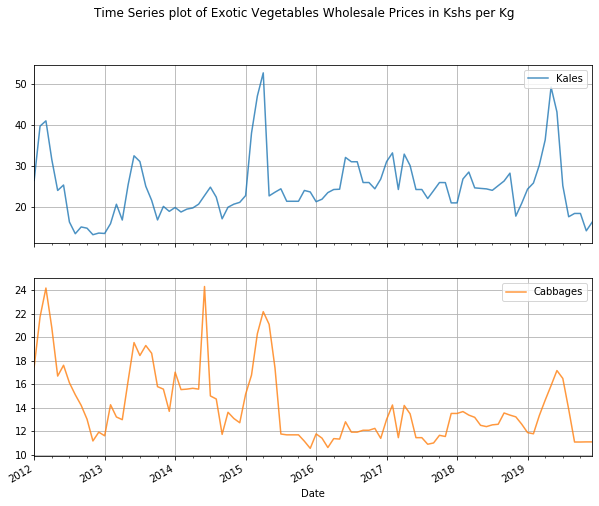

In [12]:
cols_plot = ['Kales','Cabbages']
axes = dataf[cols_plot].plot(alpha=0.8, linestyle='solid',
                          title='Time Series plot of Exotic Vegetables Wholesale Prices in Kshs per Kg',grid=True,
                          figsize=(10,8), subplots=True, sharey=False,legend=False)
[ax.legend(loc=1) for ax in plt.gcf().axes]

In [13]:
def check_for_stationarity(data):
    
    #Determining rolling statistics
    rolmean = data.rolling(12).mean()
    rolstd = data.rolling(12).std()
#Plot rolling statistics:
    plt.plot(data, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform ADF Statistic test:
    result = adfuller(data,autolag='aic')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

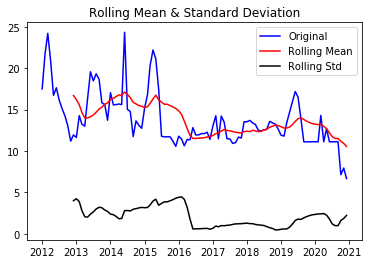

ADF Statistic: -4.246211304967911
p-value: 0.0005497643815188882
Critical Values:
	1%: -3.4942202045135513
	5%: -2.889485291005291
	10%: -2.5816762131519275


In [14]:
check_for_stationarity(df['Cabbages'])

The null hypothesis is that the time series is non-stationary

The p-value is lower than the significance level of 0.05 ADF statistic is lower than all the critical values 

Hence reject the null hypothesis and conclude that the series is stationary 

CABBAGES

In [15]:
Cabbages=pd.DataFrame()
Cabbages['Date'] = pd.to_datetime(data['Date'])
Cabbages = Cabbages.set_index('Date')
Cabbages['Cabbages'] = df['Cabbages']
Cabbages.isnull().any()

Cabbages    False
dtype: bool

In [16]:
df_Cabbages=Cabbages.drop(Cabbages.index[-12:])
df_Cabbages.isnull().any()

Cabbages    False
dtype: bool

In [17]:
Cabbages.tail()

,Cabbages
Date,
2020-08-01,11.11
2020-09-01,11.11
2020-10-01,7.14
2020-11-01,7.94
2020-12-01,6.67


In [18]:
df_Cabbages.tail()

,Cabbages
Date,
2019-08-01,13.89
2019-09-01,11.10
2019-10-01,11.10
2019-11-01,11.11
2019-12-01,11.11


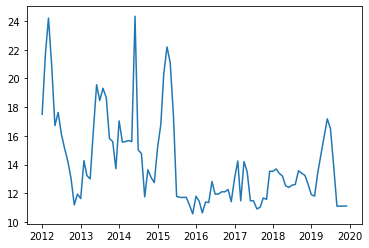

In [19]:
plt.plot(df_Cabbages)
plt.show()

In [20]:
df_seasonal = df_Cabbages.copy()
df_seasonal['Year'] = df_Cabbages.index.year
df_seasonal['Month'] = df_Cabbages.index.month

df_seasonal.head()

,Cabbages,Year,Month
Date,,,
2012-01-01,17.50,2012,1
2012-02-01,21.74,2012,2
2012-03-01,24.20,2012,3
2012-04-01,20.83,2012,4
2012-05-01,16.71,2012,5


In [21]:
month=df_seasonal.groupby('Month').agg({'Cabbages':['mean','min','max']})
month = month.round(decimals=2)
month
#months['std']= df_seasonal.groupby('Month').std()

Cabbages              
          mean    min    max
Month                       
1        13.95  11.63  17.50
2        14.94  11.43  21.74
3        15.27  10.63  24.20
4        15.64  11.39  22.19
5        15.38  11.35  21.11
6        16.60  11.47  24.33
7        14.24  11.47  18.46
8        13.78  10.91  19.31
9        13.01  11.02  18.65
10       12.81  11.10  15.81
11       12.40  11.11  15.60
12       12.20  10.56  13.71

In [22]:
mont=df_seasonal.groupby('Month').std()
mont=mont.round(decimals=2)
mont

,Cabbages,Year
Month,,
1,2.36,2.45
2,3.27,2.45
3,4.67,2.45
4,3.85,2.45
5,3.02,2.45
6,4.29,2.45
7,2.65,2.45
8,2.69,2.45
9,2.54,2.45


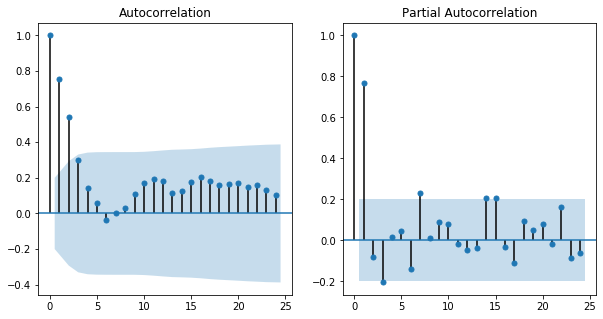

In [23]:
import statsmodels.api as sm

fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(df_Cabbages.squeeze(), lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(df_Cabbages.squeeze(), lags=24, ax=ax[1])
plt.show()

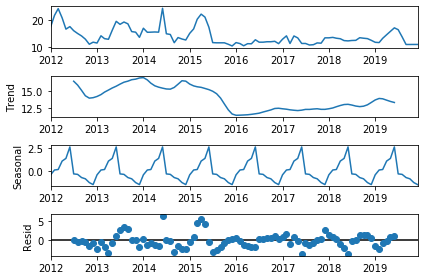

In [24]:
decomp_results = seasonal_decompose(df_Cabbages, model='additive',period=12)
type(decomp_results)

residuals = decomp_results.resid
residuals.dropna(inplace=True)

decomp_results.plot()
plt.show()

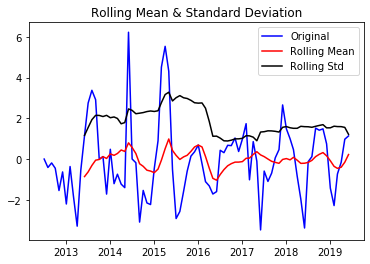

ADF Statistic: -5.976211487145167
p-value: 1.8848443317801971e-07
Critical Values:
	1%: -3.517113604831504
	5%: -2.8993754262546574
	10%: -2.5869547797501644


In [25]:
check_for_stationarity(residuals)

residuals are stationary since the ADF Statistic of -7.182265< all the critical values

In [26]:
 #Perform ADF Statistic test:
from statsmodels.tsa.stattools import adfuller
def adf_test(data):
    adf = adfuller(data,autolag='aic')
    print('ADF Statistic: {}'.format(adf[0]))
    print('p-value: {}'.format(adf[1]))
    print('Critical Values:')
    for key, value in adf[4].items():
        print('\t{}: {}'.format(key, value))

KPSS Test
Null hypothesis: process is trend stationary
Alternate hypotheis: the series has a unit root hence not stationary

In [27]:
from statsmodels.tsa.stattools import kpss

def kpss_test(timeseries):
    print('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test statistic','p-value','Lags used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical value (%s)'%key] =  value
    print(kpss_output)

In [28]:
kpss_test(df_Cabbages)

Results of KPSS Test:
Test statistic            0.569952
p-value                   0.025912
Lags used                12.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64


C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


If the test statistic is greater than the critical value,  we reject the null hypothesis (series is not stationary)
p value of 0.014752<0.05

KPSS test = stationary| ADF test  = stationary

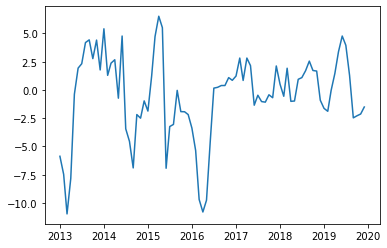

In [29]:
#SEASONAL DIFFERENCING m=12
diff_Cabbages=  pd.DataFrame()
diff_Cabbages = df_Cabbages.diff(12)
diff_Cabbages.dropna(inplace=True)

plt.plot(diff_Cabbages)
plt.show()

In [30]:
diff_Cabbages.head()

,Cabbages
Date,
2013-01-01,-5.87
2013-02-01,-7.47
2013-03-01,-10.97
2013-04-01,-7.83
2013-05-01,-0.38


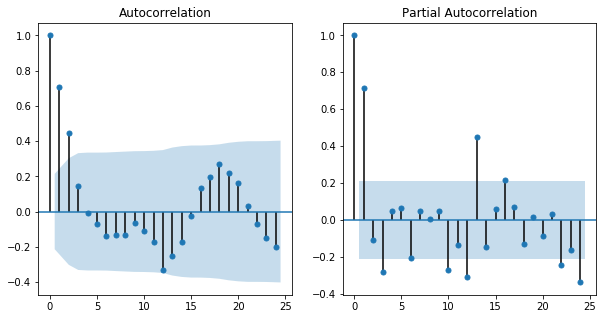

In [31]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
sm.graphics.tsa.plot_acf(diff_Cabbages.squeeze(), lags=24, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_Cabbages.squeeze(), lags=24, ax=ax[1])
plt.show()

ACF has significant spikes at lags 1 and 12
PACF has a sgnificant spike at lag (p) and spikes continue to occur after lag 1... no clarity in seasonal MA order

In [32]:
from statsmodels.graphics.tsaplots import acf, pacf

def acf_pacf(data):
    lag_acf = acf(data)
    lag_pacf = pacf(data)
#Plot ACF: 
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')

#Plot PACF:
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(data)),linestyle='--',color='gray')
    plt.title('Partial Autocorrelation Function')
    plt.tight_layout()

C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


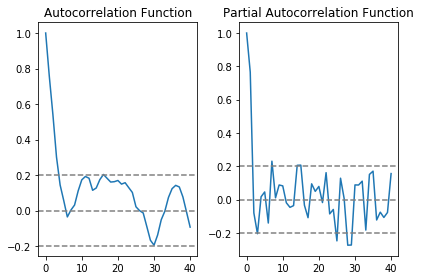

In [33]:
acf_pacf(df_Cabbages)

SARIMA

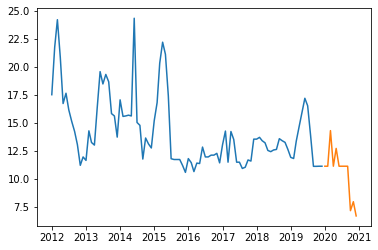

In [34]:
train = Cabbages[:96]
test = Cabbages[-12:]
plt.plot(train)
plt.plot(test)

In [35]:
# fit stepwise auto-ARIMA
arima_fit = pm.auto_arima(df_Cabbages, start_p=0, start_q=1,
                             max_p=2, max_q=2, m=12,
                             start_P=0, seasonal=True,
                             d=0, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise


Performing stepwise search to minimize aic
Fit ARIMA(0,0,1)x(0,1,1,12) [intercept=True]; AIC=394.302, BIC=404.025, Time=1.353 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=True]; AIC=463.757, BIC=468.619, Time=0.016 seconds
Fit ARIMA(1,0,0)x(1,1,0,12) [intercept=True]; AIC=391.346, BIC=401.069, Time=0.215 seconds
Fit ARIMA(0,0,0)x(0,1,0,12) [intercept=False]; AIC=463.156, BIC=465.587, Time=0.021 seconds
Fit ARIMA(1,0,0)x(0,1,0,12) [intercept=True]; AIC=405.907, BIC=413.199, Time=0.034 seconds
Fit ARIMA(1,0,0)x(2,1,0,12) [intercept=True]; AIC=384.008, BIC=396.162, Time=0.619 seconds
Fit ARIMA(1,0,0)x(2,1,1,12) [intercept=True]; AIC=380.574, BIC=395.159, Time=2.384 seconds
Near non-invertible roots for order (1, 0, 0)(2, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA(1,0,0)x(1,1,1,12) [intercept=True]; AIC=378.587, BIC=390.741, Time=0.795 seconds
Near non-invertible roots for order (1, 0, 0)(1, 1, 1, 12); setting s

In [36]:
arima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   96
Model:             SARIMAX(1, 0, 0)x(1, 1, [1], 12)   Log Likelihood                -184.293
Date:                              Fri, 11 Jun 2021   AIC                            378.587
Time:                                      12:16:48   BIC                            390.741
Sample:                                           0   HQIC                           383.472
                                               - 96                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1727      0.100     -1.721      0.085      -0.369       0.024
ar.L1          0.6968      0.068     10.265      0.000       0.564       0.830
ar.S.L12       0.0605      0.181      0.335      0.738      -0.294       0.415
ma.S.L12      -0.9984     41.093     -0.024      0.981     -81.539      79.542
sigma2         3.5323    144.645      0.024      0.981    -279.967     287.031
===================================================================================
Ljung-Box (Q):                       30.68   Jarque-Bera (JB):                 4.76
Prob(Q):                              0.86   Prob(JB):                         0.09
Heteroskedasticity (H):               0.25   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
arima_fit.fit(df_Cabbages)

ARIMA(order=(1, 0, 0), seasonal_order=(1, 1, 1, 12), suppress_warnings=True)

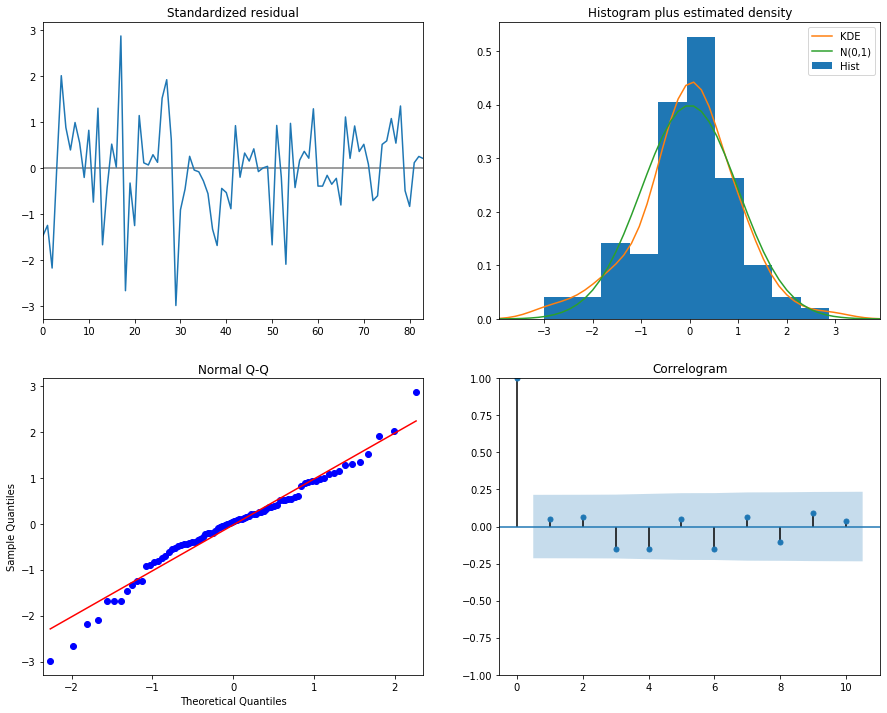

In [38]:
arima_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [39]:
#We forecast the data

future_forecast = arima_fit.predict(n_periods=12)
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Cabbages_Prediction'])
act_vs_predict=pd.concat([test,future_forecast],axis=1)
act_vs_predict = act_vs_predict.round(decimals=2)
act_vs_predict.tail(12)

,Cabbages,Cabbages_Prediction
Date,,
2020-01-01,11.11,11.85
2020-02-01,11.11,12.61
2020-03-01,14.29,12.91
2020-04-01,11.11,13.23
2020-05-01,12.70,12.98
2020-06-01,11.11,14.16
2020-07-01,11.11,11.90
2020-08-01,11.11,11.28
2020-09-01,11.11,10.37


In [40]:
act_vs_predict['diff']=act_vs_predict['Cabbages']-act_vs_predict['Cabbages_Prediction']
act_vs_predict

,Cabbages,Cabbages_Prediction,diff
Date,,,
2020-01-01,11.11,11.85,-0.74
2020-02-01,11.11,12.61,-1.50
2020-03-01,14.29,12.91,1.38
2020-04-01,11.11,13.23,-2.12
2020-05-01,12.70,12.98,-0.28
2020-06-01,11.11,14.16,-3.05
2020-07-01,11.11,11.90,-0.79
2020-08-01,11.11,11.28,-0.17
2020-09-01,11.11,10.37,0.74


In [41]:
act_vs_predict['diff'].min()

-3.0500000000000007

In [42]:
act_vs_predict['diff'].max()

1.379999999999999

In [43]:
index_date =['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
             '2020-09-01', '2020-10-01', '2020-11-01','2020-12-01',
             '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
             '2021-09-01', '2021-10-01', '2021-11-01','2021-12-01']
index = pd.to_datetime(index_date)
index

DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01'],
              dtype='datetime64[ns]', freq=None)

In [44]:
kales=pd.DataFrame()
kales['Date']= index
kales=kales.set_index(index)

In [45]:
predict= arima_fit.predict(n_periods=24)
predict= pd.DataFrame(predict,index=kales.index,columns=['Forecast'])
predict = predict.round(decimals=2)
predict.head()

,Forecast
2020-01-01,11.85
2020-02-01,12.61
2020-03-01,12.91
2020-04-01,13.23
2020-05-01,12.98


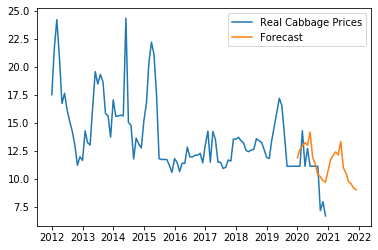

In [46]:
#plot the predictions for validation set
plt.plot(Cabbages,label='Real Cabbage Prices')
plt.plot(predict, label='Forecast')
plt.legend()
plt.show()

In [47]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(act_vs_predict['Cabbages'], act_vs_predict['Cabbages_Prediction']))
print('Mean Squared Error:', metrics.mean_squared_error(act_vs_predict['Cabbages'], act_vs_predict['Cabbages_Prediction']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(act_vs_predict['Cabbages'], 
                                                                     act_vs_predict['Cabbages_Prediction'])))
MAPE = metrics.mean_absolute_error(act_vs_predict['Cabbages'], act_vs_predict['Cabbages_Prediction'])*100
print('Mean Absolute Perecentage Error:',MAPE)

Mean Absolute Error: 1.5583333333333336
Mean Squared Error: 3.4678333333333335
Root Mean Squared Error: 1.8622119464049556
Mean Absolute Perecentage Error: 155.83333333333337


In [48]:
best_model = SARIMAX(df_Cabbages, order=(1,0,1), seasonal_order=(0,1,1,12)).fit(dis=-1)
print(best_model.summary())

C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                                     SARIMAX Results                                      
Dep. Variable:                           Cabbages   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -186.244
Date:                            Fri, 11 Jun 2021   AIC                            380.488
Time:                                    12:16:52   BIC                            390.211
Sample:                                01-01-2012   HQIC                           384.396
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7352      0.107      6.899      0.000       0.526       0.944
ma.L1          0.0530      0.138   

HOLT'S WINTERS METHOD

In [49]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as HWES

model = HWES(df_Cabbages, seasonal_periods=12,seasonal='mul')
fitted = model.fit()

C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\user\Downloads\Anaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [50]:
print(fitted.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   96
Model:             ExponentialSmoothing   SSE                            458.259
Optimized:                         True   AIC                            178.056
Trend:                             None   BIC                            213.957
Seasonal:                Multiplicative   AICC                           184.942
Seasonal Periods:                    12   Date:                 Fri, 11 Jun 2021
Box-Cox:                          False   Time:                         12:16:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.6842105                alpha                 True
smoothing_seasonal       

In [51]:
forecast_12= fitted.forecast(12)
forecast_12 = pd.DataFrame(forecast_12,index = test.index,columns=['Cabbages_Prediction'])
predict_12= pd.concat([test,forecast_12],axis=1)
predict_12= predict_12.round(decimals=2)
predict_12

,Cabbages,Cabbages_Prediction
Date,,
2020-01-01,11.11,11.80
2020-02-01,11.11,12.53
2020-03-01,14.29,12.98
2020-04-01,11.11,13.77
2020-05-01,12.70,13.70
2020-06-01,11.11,13.73
2020-07-01,11.11,12.64
2020-08-01,11.11,11.21
2020-09-01,11.11,10.57


In [52]:
print('Mean Absolute Error:', metrics.mean_absolute_error(predict_12['Cabbages'], predict_12['Cabbages_Prediction']))
print('Mean Squared Error:', metrics.mean_squared_error(predict_12['Cabbages'], predict_12['Cabbages_Prediction']))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(predict_12['Cabbages'], 
                                                                     predict_12['Cabbages_Prediction'])))

Mean Absolute Error: 1.9233333333333331
Mean Squared Error: 5.408083333333334
Root Mean Squared Error: 2.3255286137421174


In [53]:
forecast = fitted.forecast(24)

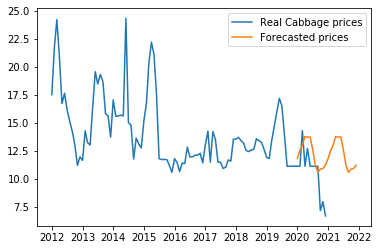

In [54]:
plt.plot(Cabbages,label='Real Cabbage prices')
plt.plot(forecast, label='Forecasted prices')
plt.legend()
plt.show()

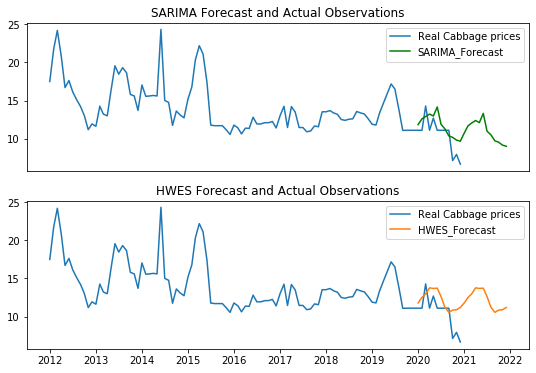

In [55]:
plt.figure(figsize=(9,6))

plt.subplot(211)
plt.title('SARIMA Forecast and Actual Observations')
plt.plot(Cabbages, label='Real Cabbage prices')
plt.plot(predict, label='SARIMA_Forecast',color='green')
plt.xticks([])
plt.legend()

plt.subplot(212)
plt.title('HWES Forecast and Actual Observations')
plt.plot(Cabbages , label='Real Cabbage prices')
plt.plot(forecast, label='HWES_Forecast')
plt.legend()

plt.show()